## IMPORT

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, boxcox
from collections import Counter
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, ConfusionMatrixDisplay, explained_variance_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVR
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputRegressor

import warnings
warnings.simplefilter("ignore")

## PLOT

#### WHAT'S IN THIS DATASET?

**The European Football Database for data analysis and machine learning:**

* +25,000 matches
* +10,000 players
* 11 European Countries with their lead championship
* Seasons 2008 to 2016
* Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates - - Team line up with squad formation (X, Y coordinates)
* Betting odds from up to 10 providers
* Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches

#### OBJECTIVES

* Practice identifying opportunities for data analysis, raising hypothesis, and formulating research tasks.
* Practice performing EDA, statistical inference, and prediction.
* Practice working with SQL datasets.
* Practice visualizing data.

## DATA PREPROCESSING AND CLEANING

In [12]:
def title_and_labels(title, x_label, y_label):
    ''' Defining fontsize for plots '''
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)

In [3]:
def percentage_of_nulls(dataset):
    return dataset.isnull().sum() * 100 / len(dataset)

In [2]:
# connect the dataset and list available tables inside dataset
con = sqlite3.connect("database.sqlite")

pd.read_sql('''SELECT name
               FROM sqlite_master
               WHERE type = 'table'
               ;''', con)

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


There are 7 different tables in total with various information for players, its attributes, team and its attributes, countries, leagues and matches.

In [3]:
sqlite_seq_df = pd.read_sql_query('SELECT * FROM sqlite_sequence', con)
player_att_df = pd.read_sql_query('SELECT * FROM Player_Attributes', con)
player_df = pd.read_sql_query('SELECT * FROM Player', con)
match_df = pd.read_sql_query('SELECT * FROM Match', con)
league_df = pd.read_sql_query('SELECT * FROM League', con)
country_df = pd.read_sql_query('SELECT * FROM Country', con)
team_df = pd.read_sql_query('SELECT * FROM Team', con)
team_att_df = pd.read_sql_query('SELECT * FROM Team_Attributes', con)

## Countries

There are teams of 10 different countries

In [4]:
country_df = pd.read_sql('''SELECT *
                           FROM Country
                           ;''', con)
country_df

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


## Leagues

10 different Leagues are present

In [7]:
league_df = pd.read_sql_query('''SELECT * 
                                 FROM League
                                 ;''', con)

league_df

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


## Teams

There are 299 teams throughout this dataset

In [5]:
team_df = pd.read_sql_query('''SELECT * 
                               FROM Team
                               ;''', con)

team_df

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
...,...,...,...,...,...
294,49479,10190,898.0,FC St. Gallen,GAL
295,49837,10191,1715.0,FC Thun,THU
296,50201,9777,324.0,Servette FC,SER
297,50204,7730,1862.0,FC Lausanne-Sports,LAU


Let's check if there are any duplicates here

In [9]:
print(f'Number of dublicates: {team_df.duplicated().sum()}\nAmount of total: {round(team_df.duplicated().sum()/len(team_df)*100, 2)}%')

Number of dublicates: 0
Amount of total: 0.0%


In [10]:
# percentage of null values
percentage_of_nulls(team_df)

id                  0.00000
team_api_id         0.00000
team_fifa_api_id    3.67893
team_long_name      0.00000
team_short_name     0.00000
dtype: float64

There are some null values in `team_fifa_api_id` field, but we'll use `team_api_id` to join tables instead, thus we may drop this column.

In [11]:
team_df.drop(columns=['team_fifa_api_id'], inplace=True)

## Players

In [6]:
player_df = pd.read_sql_query('''SELECT * 
                                 FROM Player
                                 ;''', con)

player_df.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [13]:
print(f'Number of dublicates: {player_df.duplicated().sum()}\nAmount of total: {round(player_df.duplicated().sum()/len(player_df)*100, 2)}%')

Number of dublicates: 0
Amount of total: 0.0%


In [14]:
no_of_players = len(player_att_df.player_api_id.unique())
print(f'There are total of {no_of_players} players')

There are total of 11060 players


In [15]:
# percentage of null values
percentage_of_nulls(player_df)

id                    0.0
player_api_id         0.0
player_name           0.0
player_fifa_api_id    0.0
birthday              0.0
height                0.0
weight                0.0
dtype: float64

We'll drop redundant columns `id` and `player_fifa_api_id`, as to identify a player we'll use `player_api_id` as a foreign key.

In [16]:
player_df.drop(columns=['id', 'player_fifa_api_id'], inplace=True)

## Player Attributes

A big dataset with 183978 instances keeps information about all {{no_of_players}} different players. It presents statistics of every player throughout different periods of his career.

In [7]:
player_att_df = pd.read_sql_query('''SELECT * 
                                     FROM Player_Attributes
                                     ;''', con)

player_att_df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [18]:
print(f'Number of dublicates: {player_att_df.duplicated().sum()}\nAmount of total: {round(player_att_df.duplicated().sum()/len(player_att_df)*100, 2)}%')

Number of dublicates: 0
Amount of total: 0.0%


In [19]:
percentage_of_nulls(player_att_df)

id                     0.000000
player_fifa_api_id     0.000000
player_api_id          0.000000
date                   0.000000
overall_rating         0.454402
potential              0.454402
preferred_foot         0.454402
attacking_work_rate    1.755645
defensive_work_rate    0.454402
crossing               0.454402
finishing              0.454402
heading_accuracy       0.454402
short_passing          0.454402
volleys                1.474633
dribbling              0.454402
curve                  1.474633
free_kick_accuracy     0.454402
long_passing           0.454402
ball_control           0.454402
acceleration           0.454402
sprint_speed           0.454402
agility                1.474633
reactions              0.454402
balance                1.474633
shot_power             0.454402
jumping                1.474633
stamina                0.454402
strength               0.454402
long_shots             0.454402
aggression             0.454402
interceptions          0.454402
position

Interesting, we see that some features has equal amount of Null values. Let's check this out.

In [20]:
player_att_df[player_att_df.isna().any(axis=1)].sample(5)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
87620,87621,146462,74739,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137591,137592,113398,38890,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77472,77473,171790,22732,2007-08-30 00:00:00,65.0,66.0,right,norm,ormal,58.0,...,NaN,67.0,67.0,64.0,NaN,9.0,23.0,47.0,23.0,23.0
98398,98399,8998,26621,2008-08-30 00:00:00,63.0,74.0,right,None,_0,43.0,...,NaN,69.0,63.0,76.0,NaN,14.0,22.0,30.0,22.0,22.0
79299,79300,1742,26123,2008-08-30 00:00:00,74.0,79.0,right,None,_0,43.0,...,NaN,71.0,23.0,21.0,NaN,8.0,21.0,41.0,21.0,21.0


First of all there is at least 4 types of 'no data' markings: **NaN, None, 'None', '_0' and 'o'**

So lets equalize no data markings and change all to **NaN**.

In [21]:
for i in [None, 'None', '_0', 'o']:
    player_att_df.replace({i: np.nan}, inplace=True)

Now let's check are there any players with no data throughout all features (except the id features)

In [22]:
empty_players = player_att_df[player_att_df.iloc[:, 4:].isnull().all(axis=1)]
empty_players.head(3)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
483,484,33022,31684,2007-02-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,984,111085,29904,2007-02-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1753,165740,24159,2007-02-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
len(empty_players)

836

We'll drop these rows

In [24]:
ids_to_drop = player_att_df[player_att_df.iloc[:, 4:].isnull().all(axis=1)].index
player_att_df.drop(index=ids_to_drop, inplace=True)

Features `attacking_work_rate` and `defensive_work_rate` should have only values of: **high**, **medium** and **low**, but in reality there is inconsistency in the data.

Source: [fifplay.com](https://www.fifplay.com/encyclopedia/work-rate)

In [25]:
player_att_df.attacking_work_rate.value_counts()

medium    125070
high       42823
low         8569
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64

In [26]:
player_att_df.defensive_work_rate.value_counts()

medium    130846
high       27041
low        18432
1            441
ormal        348
2            342
3            258
5            234
7            217
0            197
6            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64

Since we don't know what values may be hidden behind these meaningless names, and blind guesses may be wrong, there are basically two ways to go about it: either drop it, but lose a certain amount of data, or replace it with NaN and later, if we'll use these features, try to predict the values. Let's do that.

In [27]:
player_att_df['attacking_work_rate'].replace(to_replace=['norm','y','le','stoc'], value=np.nan, inplace=True)
player_att_df['defensive_work_rate'].replace(to_replace=['ormal','1','2','3','4','5','6','7','8','9','0','es','ean','tocky'], value=np.nan, inplace=True)

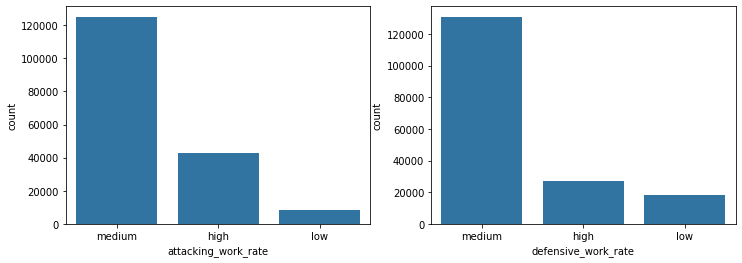

In [28]:
f, ax = plt.subplots(1,2, figsize=(12, 4))

for i, feat in enumerate(['attacking_work_rate', 'defensive_work_rate']):
    sns.countplot(x=feat, data=player_att_df, ax=ax[i], color='#1F77B4')

So now we'll leave dataset as it is and then later we'll try to predict the missing values.

<!-- Recheck for null values: -->

In [29]:
percentage_of_nulls(player_att_df)

id                     0.000000
player_fifa_api_id     0.000000
player_api_id          0.000000
date                   0.000000
overall_rating         0.000000
potential              0.000000
preferred_foot         0.000000
attacking_work_rate    3.647443
defensive_work_rate    3.725524
crossing               0.000000
finishing              0.000000
heading_accuracy       0.000000
short_passing          0.000000
volleys                1.024888
dribbling              0.000000
curve                  1.024888
free_kick_accuracy     0.000000
long_passing           0.000000
ball_control           0.000000
acceleration           0.000000
sprint_speed           0.000000
agility                1.024888
reactions              0.000000
balance                1.024888
shot_power             0.000000
jumping                1.024888
stamina                0.000000
strength               0.000000
long_shots             0.000000
aggression             0.000000
interceptions          0.000000
position

## Team attributes

Table for team attribute data. It presents statistics of teams throughout different periods of time.

In [30]:
team_att_df = pd.read_sql_query('''SELECT * 
                                   FROM Team_Attributes
                                   ;''', con)

team_att_df.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [31]:
print(f'Number of dublicates: {team_att_df.duplicated().sum()}\nAmount of total: {round(team_att_df.duplicated().sum()/len(team_att_df)*100, 2)}%')

Number of dublicates: 0
Amount of total: 0.0%


In [32]:
len(team_att_df.team_api_id.unique())

288

Some teams are missing in this dataset, that are present in Teams dataset

In [33]:
missing_teams = team_df[['team_api_id', 'team_long_name']].merge(team_att_df['team_api_id'], how='left', indicator=True)

In [34]:
missing_teams[missing_teams['_merge'] == 'left_only']

,team_api_id,team_long_name,_merge
43,7947,FCV Dender EH,left_only
69,4049,Tubize,left_only
907,6601,FC Volendam,left_only
1041,177361,Termalica Bruk-Bet Nieciecza,left_only
1057,7992,Trofense,left_only
1082,10213,Amadora,left_only
1124,9765,Portimonense,left_only
1128,4064,Feirense,left_only
1142,6367,Uniao da Madeira,left_only
1143,188163,Tondela,left_only


In [35]:
percentage_of_nulls(team_att_df)

id                                 0.000000
team_fifa_api_id                   0.000000
team_api_id                        0.000000
date                               0.000000
buildUpPlaySpeed                   0.000000
buildUpPlaySpeedClass              0.000000
buildUpPlayDribbling              66.460905
buildUpPlayDribblingClass          0.000000
buildUpPlayPassing                 0.000000
buildUpPlayPassingClass            0.000000
buildUpPlayPositioningClass        0.000000
chanceCreationPassing              0.000000
chanceCreationPassingClass         0.000000
chanceCreationCrossing             0.000000
chanceCreationCrossingClass        0.000000
chanceCreationShooting             0.000000
chanceCreationShootingClass        0.000000
chanceCreationPositioningClass     0.000000
defencePressure                    0.000000
defencePressureClass               0.000000
defenceAggression                  0.000000
defenceAggressionClass             0.000000
defenceTeamWidth                

We see that only feature that has missing data is `buildUpPlayDribbling` and more than 66% of it is NaN, thus we'll just drop it.

In [36]:
team_att_df.drop(columns=['buildUpPlayDribbling'], inplace=True)

## Match

A large dataset with 25979 instances and 115 features. This dataset contains detailed data on football matches that have taken place (league, teams, home ground, players, goals, scores, results, bookmakers' odds etc.)

In [37]:
match_df = pd.read_sql_query('''SELECT * 
                                FROM Match
                                ;''', con)

match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [38]:
print(f'Number of dublicates: {team_att_df.duplicated().sum()}\nAmount of total: {round(team_att_df.duplicated().sum()/len(team_att_df)*100, 2)}%')

Number of dublicates: 0
Amount of total: 0.0%


In [39]:
pd.set_option("display.max_columns", None)

In [40]:
for i in [None, 'None', '_0']:
    match_df.replace({i: np.nan}, inplace=True)

In [41]:
percentage_of_nulls(match_df)

id             0.000000
country_id     0.000000
league_id      0.000000
season         0.000000
stage          0.000000
                ...    
GBD           45.486739
GBA           45.486739
BSH           45.490589
BSD           45.490589
BSA           45.490589
Length: 115, dtype: float64

There is big amount of missing data for features of **`PSH, PSD, PSA`** and **`GBH, GBD, GBA, BSH, BSD, BSA`** (various bookmakers' odds).

**57%** and **45%** respectively.

In this context, we will drop these features.

In [42]:
match_df.drop(columns=['PSH', 'PSD', 'PSA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],inplace=True)

In [43]:
match_df.loc[:,['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']].sample(4)

,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
5237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24107,<goal><value><comment>p</comment><stats><penal...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>52</comment><stats...
7437,<goal><value><comment>npm</comment><elapsed_pl...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>36</comment><stats...
17435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Features **`goal, shoton, shotoff, foulcommit, card, cross, corner, possession`** holds XML type information. It has equally a lot of NaN (more than 45%). Besides, in every of these features there are a lot of incosistent data too, like empty XML tag. We'll replace these with NaN as well.

In [44]:
match_df.replace(to_replace=['<goal />', '<shoton />', '<shotoff />', '<foulcommit />', '<card />', '<cross />', '<corner />', '<possession />'], value=np.nan, inplace=True)

In [45]:
percentage_of_nulls(match_df.loc[:,['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']])

goal          49.097348
shoton        67.423688
shotoff       67.423688
foulcommit    67.415990
card          46.972555
cross         67.415990
corner        67.419839
possession    67.593056
dtype: float64

There is now even more NaN data, however this information is too important yet to be deleted. We will therefore leave it as it is for now.

## EDA

**There are some required questions to be answered for this project**

* Which leagues are in which countries?
* Which leagues score the most/fewest goals?
* Who are the top scorers in each team and league?
* Is there such a thing as home advantage?
* Can we predict how many goals each team will score in each match?
* Can we predict which team will win the match?

### Which leagues are in which countries?

In [46]:
pd.read_sql_query('''SELECT 
                         l.name as league_name,
                         c.name as country
                     FROM League as l
                     JOIN Country as c
                     ON l.id = c.id
                     ;''', con)

,league_name,country
0,Belgium Jupiler League,Belgium
1,England Premier League,England
2,France Ligue 1,France
3,Germany 1. Bundesliga,Germany
4,Italy Serie A,Italy
5,Netherlands Eredivisie,Netherlands
6,Poland Ekstraklasa,Poland
7,Portugal Liga ZON Sagres,Portugal
8,Scotland Premier League,Scotland
9,Spain LIGA BBVA,Spain


### Which leagues score the most/fewest goals?

In [47]:
min_max_df = pd.read_sql_query(''' WITH goals_per_league AS (
                                           SELECT 
                                               m.league_id, 
                                               l.name,
                                               SUM(m.home_team_goal + m.away_team_goal) AS goals
                                           FROM Match AS m
                                           JOIN League AS l
                                           ON m.league_id = l.id
                                           GROUP BY 1, 2)
                                   SELECT name, goals
                                   FROM goals_per_league
                                   WHERE goals = (SELECT MIN(goals) FROM goals_per_league)
                                   UNION
                                   SELECT name, goals
                                   FROM goals_per_league
                                   WHERE goals = (SELECT MAX(goals) FROM goals_per_league)
                                   ;''', con)

for i, adj in enumerate(['highest', 'lowest']):
    print(f'The {adj} score league is "{min_max_df.name[i]}" with {min_max_df.goals[i]} goals in total')

The highest score league is "Spain LIGA BBVA" with 8412 goals in total
The lowest score league is "Switzerland Super League" with 4166 goals in total


### Who are the top scorers in each team and league?

Regrettably, there is a lot of missing data (49%) on the feature that stores information about **players who have scored goals**. Therefore, this data does not necessarily reflects the actual data.

In [48]:
scorers_df = pd.DataFrame()
for j, i in enumerate(match_df.goal):
    if not pd.isnull(i):
        xml_extr = pd.read_xml(i)
        try:
            frame = pd.merge(xml_extr.assign(key=j), match_df.loc[[j], ['league_id']].assign(key=j), on='key').drop('key', axis=1)
            scorers_df = pd.concat([scorers_df, frame[['player1', 'team', 'league_id']]])
        except KeyError:
            continue

In [49]:
top_scorers_df = pd.DataFrame({'score': scorers_df.groupby(['player1', 'league_id', 'team'])['player1'].count()}).sort_values(by='score', ascending=False).reset_index()
top_scorers_df = top_scorers_df.merge(player_df[['player_name', 'player_api_id']], left_on='player1', right_on='player_api_id')
top_scorers_df = top_scorers_df.merge(team_df[['team_long_name', 'team_api_id', ]], left_on='team', right_on='team_api_id')
top_scorers_df = top_scorers_df.merge(league_df[['name', 'id', ]], left_on='league_id', right_on='id')
top_scorers_df.drop(columns=['league_id', 'id', 'team_api_id', 'team', 'player1', 'player_api_id'], inplace=True)

**Players who have scored the most goals in every league**

In [50]:
top_scorers_df.loc[top_scorers_df.groupby(['name'], sort=False)['score'].idxmax()][['player_name', 'score', 'name', 'team_long_name']]

,player_name,score,name,team_long_name
0,Lionel Messi,295,Spain LIGA BBVA,FC Barcelona
1250,Wayne Rooney,135,England Premier League,Manchester United
2472,Antonio Di Natale,156,Italy Serie A,Udinese
3811,Zlatan Ibrahimovic,120,France Ligue 1,Paris Saint-Germain
4803,Stefan Kiessling,112,Germany 1. Bundesliga,Bayer 04 Leverkusen
5877,Luuk de Jong,47,Netherlands Eredivisie,PSV
6238,Kenny Miller,7,Scotland Premier League,Rangers
6259,Guillaume Hoarau,17,Switzerland Super League,BSC Young Boys
6369,Artjoms Rudnevs,3,Poland Ekstraklasa,Lech Poznań


**Players with the most goals in their teams**

In [51]:
top_scorers_df.loc[top_scorers_df.groupby(['team_long_name'])['score'].idxmax()][['player_name', 'score', 'team_long_name', 'name']].sort_values(by='score', ascending=False)

,player_name,score,team_long_name,name
0,Lionel Messi,295,FC Barcelona,Spain LIGA BBVA
41,Cristiano Ronaldo,270,Real Madrid CF,Spain LIGA BBVA
2472,Antonio Di Natale,156,Udinese,Italy Serie A
1250,Wayne Rooney,135,Manchester United,England Premier League
3811,Zlatan Ibrahimovic,120,Paris Saint-Germain,France Ligue 1
...,...,...,...,...
4401,Remy Cabella,3,AC Arles-Avignon,France Ligue 1
6214,"Jeffry Fortes,30",3,FC Dordrecht,Netherlands Eredivisie
6370,Danijel Ljuboja,1,Legia Warszawa,Poland Ekstraklasa
6373,Pavel Sultes,1,P. Warszawa,Poland Ekstraklasa


#### Teams with most goals in every league

In [52]:
team_scores = pd.read_sql_query('''  SELECT 
                                         sub.team AS team,
                                         t.team_long_name,
                                         l.name,
                                         SUM(sub.goals) AS goals
                                     FROM (SELECT 
                                               home_team_api_id AS team,
                                               league_id,
                                               SUM(home_team_goal) AS goals
                                           FROM Match
                                           GROUP BY 1
                                           UNION
                                           SELECT 
                                               away_team_api_id AS team,
                                               league_id,
                                               SUM(away_team_goal) AS goals
                                           FROM Match
                                           GROUP BY 1) AS sub
                                     JOIN Team AS t
                                     ON t.team_api_id = sub.team
                                     JOIN League AS l
                                     ON l.id = sub.league_id
                                     GROUP BY 1, 2, 3
                                     ;''', con)

In [53]:
team_scores.loc[team_scores.groupby(['name'])['goals'].idxmax()][['name', 'team_long_name', 'goals']].sort_values(by='goals', ascending=False)

,name,team_long_name,goals
141,Spain LIGA BBVA,FC Barcelona,849
233,Scotland Premier League,Celtic,695
191,Germany 1. Bundesliga,FC Bayern Munich,653
145,Netherlands Eredivisie,PSV,652
236,Switzerland Super League,FC Basel,619
88,England Premier League,Manchester City,606
202,France Ligue 1,Paris Saint-Germain,568
174,Portugal Liga ZON Sagres,SL Benfica,568
223,Italy Serie A,Juventus,543
142,Belgium Jupiler League,RSC Anderlecht,427


### Is there such a thing as home advantage?

First we'll write a function to calculate a string type match result of **Draw**, **Win** or **Lose** and apply it to two new features `home_team_res` and `away_team_res`.

In [9]:
def match_result(row):
    if row['home_team_goal'] - row['away_team_goal'] == 0:
        home_team_res, away_team_res = 'Draw', 'Draw'
    elif row['home_team_goal'] - row['away_team_goal'] < 0:
        home_team_res, away_team_res = 'Lose', 'Win'
    else:
        home_team_res, away_team_res = 'Win', 'Lose'
    return [home_team_res, away_team_res]

In [10]:
match_df[['home_team_res', 'away_team_res']] = match_df.apply(match_result, axis = 1, result_type="expand")

In [14]:
plot_data

,home_team_res
Win,45.871666
Lose,28.738597
Draw,25.389738


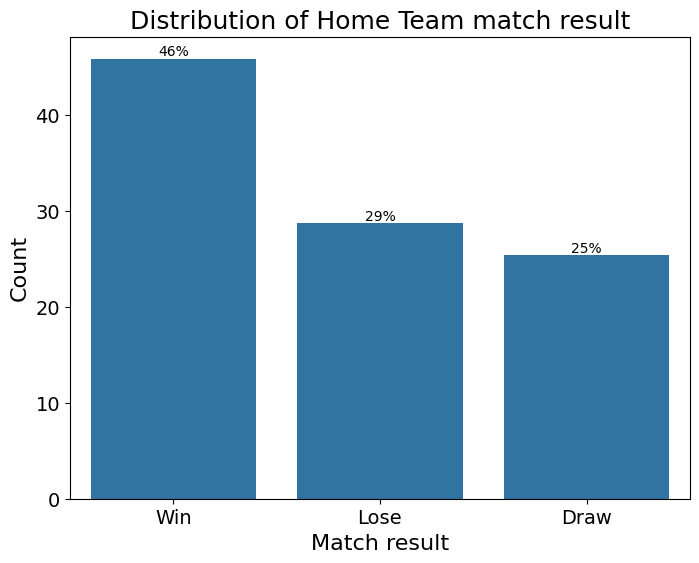

In [13]:
plot_data = pd.DataFrame(match_df['home_team_res'].value_counts(normalize=True)*100)

plt.figure(figsize=(8,6))
ax = sns.barplot(y='home_team_res', x=plot_data.index, data=plot_data, color='#1F77B4')
plt.bar_label(ax.containers[0], fmt='%.0f%%')
title_and_labels(
    title='Distribution of Home Team match result',
    x_label='Match result',
    y_label='Count')

From the graph above we see that **46%** of times **Home team wins**.

Let's see the distribution of amount of goals during the match

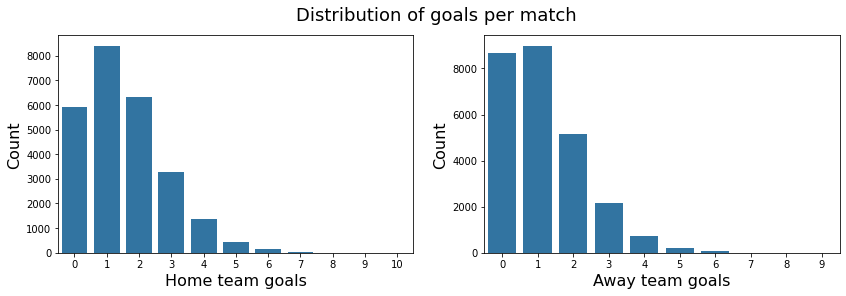

In [57]:
f, ax = plt.subplots(1,2, figsize=(14, 4))

for i, feat in enumerate(['home_team_goal', 'away_team_goal']):
    sns.countplot(x=feat, data=match_df, ax=ax[i], color='#1F77B4')
    ax[i].set_ylabel("Count", fontsize=16)

plt.suptitle('Distribution of goals per match', fontsize=18)
ax[0].set_xlabel("Home team goals", fontsize=16)
ax[1].set_xlabel("Away team goals", fontsize=16)
plt.show()


We see that even the chances of scoring at least 1 goal for both teams are relatively close, but it is more likely for Away team of not scoring at all than for the Home team

In [58]:
def read_extract(row, column, xml_key, away_or_home):
    count = 0
    if not pd.isnull(row[column]):
        for i in pd.read_xml(row[column])[xml_key]:
            if i == row[away_or_home + '_team_api_id']:
                count += 1
    else:
        return row[away_or_home + '_team_goal']
    return count

In [59]:
match_df['shoton_away'] = match_df.apply(lambda x : read_extract(x, 'shoton' , 'team' , 'away'), axis = 1)
match_df['shoton_home'] = match_df.apply(lambda x : read_extract(x, 'shoton' , 'team' , 'home'), axis = 1)
match_df['shotoff_home'] = match_df.apply(lambda x : read_extract(x, 'shotoff' , 'team' , 'away'), axis = 1)
match_df['shotoff_away'] = match_df.apply(lambda x : read_extract(x, 'shotoff' , 'team' , 'home'), axis = 1)

In [60]:
match_df.iloc[:,-4:].sample(5)

,shoton_away,shoton_home,shotoff_home,shotoff_away
4730,4,16,4,6
16817,0,2,0,2
18885,2,2,2,2
7025,0,2,0,2
10122,4,5,6,12


In [61]:
shotons = match_df[["shoton_away", "shoton_home"]]

In [62]:
shotons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   shoton_away  25979 non-null  int64
 1   shoton_home  25979 non-null  int64
dtypes: int64(2)
memory usage: 406.0 KB


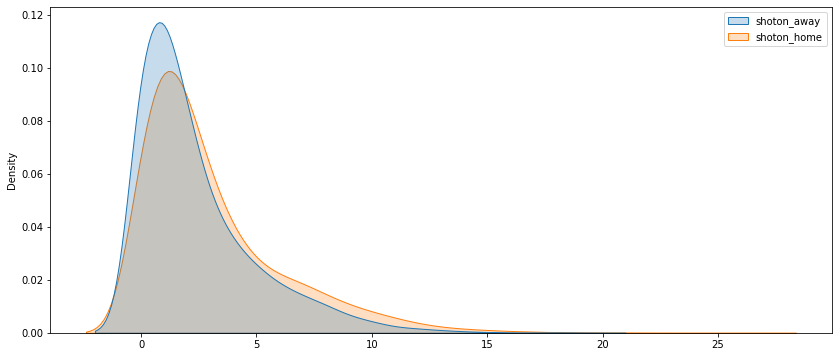

In [63]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=match_df[["shoton_away", "shoton_home"]], shade=True,legend=True, bw_adjust=2)
plt.show()

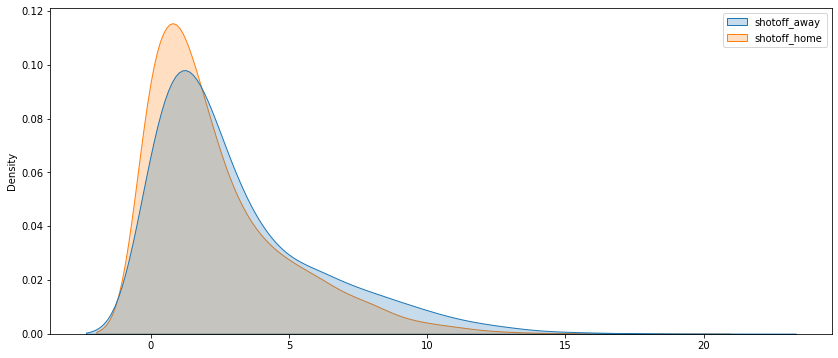

In [64]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=match_df[["shotoff_away", "shotoff_home"]], shade=True,legend=True, bw_adjust=2)
plt.show()

Home team is a bit ahead as well in a shots on goal attempts (has more opportunities), as well as Away team is a bit ahead of shots off. 

### Players

Let's compare the overall_rating and overall_potential of the players.

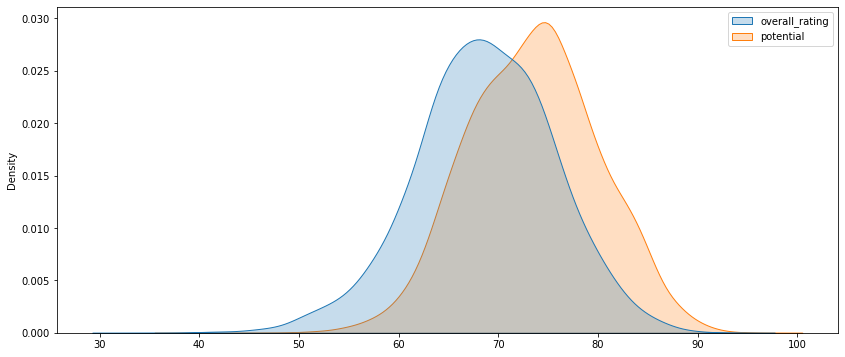

In [65]:
plt.figure(figsize=(14,6))

sns.kdeplot(data=player_att_df[["overall_rating", "potential"]], shade=True, legend=True, bw_adjust=2)
plt.show()

As it is seen, players potential mostly is slightly higher than his actual rating.

In [66]:
potential_diff = pd.DataFrame({'diff':player_att_df['potential'] - player_att_df['overall_rating']})

def player_potential(row):
    if row['diff'] > 0:
        return 'No'
    else:
        return 'Yes'

potential_diff['exceeds'] = potential_diff.apply(player_potential, axis=1)

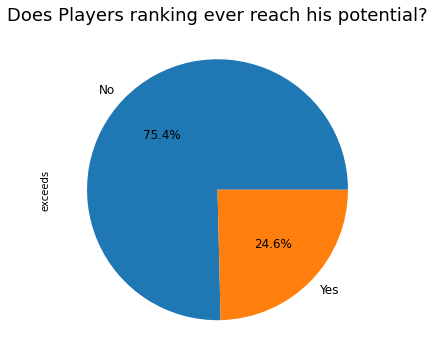

In [67]:
plt.figure(figsize=(8,6))
potential_diff['exceeds'].value_counts().plot(kind='pie', autopct='%1.1f%%', textprops={'fontsize': 12})
plt.title('Does Players ranking ever reach his potential?', fontsize=18)
plt.show()

From the above graph we may see that only 1/4 of all players ratings ever reach their potential.

In [68]:
player_df

,player_api_id,player_name,birthday,height,weight
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
1,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146
2,162549,Aaron Doran,1991-05-13 00:00:00,170.18,163
3,30572,Aaron Galindo,1982-05-08 00:00:00,182.88,198
4,23780,Aaron Hughes,1979-11-08 00:00:00,182.88,154
...,...,...,...,...,...
11055,26357,Zoumana Camara,1979-04-03 00:00:00,182.88,168
11056,111182,Zsolt Laczko,1986-12-18 00:00:00,182.88,176
11057,36491,Zsolt Low,1979-04-29 00:00:00,180.34,154
11058,35506,Zurab Khizanishvili,1981-10-06 00:00:00,185.42,172


Does physical players data like height or weight has correlation with his overall rating?

In [69]:
physical_data_rating = pd.DataFrame(player_att_df.groupby(['player_api_id'])['overall_rating'].mean()).reset_index().merge(player_df[['weight', 'height', 'player_api_id']], on='player_api_id')

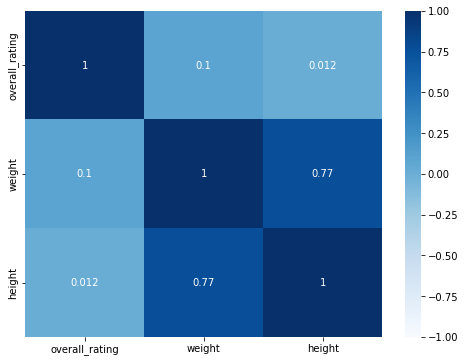

In [70]:
plt.figure(figsize=(8,6))
sns.heatmap(physical_data_rating.drop(columns=['player_api_id']).corr(method='pearson'), annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.show()

There is no, or it is very weak

## Predicting the missing values for Players Attributes

So currently we are missing data of features for two types:

Categorical: `attacking_work_rate`, `defensive_work_rate`

Continuous: `volleys`, `curve`, `agility`, `balance`, `jumping`, `vision`, `sliding_tackle`

In [71]:
def linear_predicting_missing_val(df, feature):
    model = LinearRegression()
    df = df.select_dtypes(exclude=['object', 'int64'])
    
    null_features = df.isna().any()
    null_features[feature] = False
    
    test_data = df.loc[:, ~null_features][df[feature].isnull()]
    
    train_data = df.loc[:, ~null_features]
    train_data = train_data.dropna()
    
    x_train, y_train = train_data.drop(feature, axis=1), train_data[feature]
    
    model.fit(x_train, y_train)
    x_test = test_data.drop(feature, axis=1)
    y_pred = model.predict(x_test)

    return y_pred

In [72]:
def logistic_predicting_missing_val(df, feature):
    model = LogisticRegression(solver='liblinear', random_state=0)
    df = player_att_df.select_dtypes(exclude=['int64'])
    df = df.drop(columns=['preferred_foot', 'date'])
    
    null_features = df.isna().any()
    null_features[feature] = False
    
    test_data = df.loc[:, ~null_features][df[feature].isnull()]
    
    train_data = df.loc[:, ~null_features]
    train_data = train_data.dropna()
    
    x_train, y_train = train_data.drop(feature, axis=1), train_data[feature]
    
    model.fit(x_train, y_train)
    x_test = test_data.drop(feature, axis=1)
    y_pred = model.predict(x_test)
    
    return y_pred

In [73]:
def concat_predictions(df, df_for_pred):
    df.drop(index=df_for_pred.index, inplace=True)
    df = pd.concat([df, df_for_pred])
    return df

Testing prediction accuracy Logistic Regression

In [74]:
x = player_att_df.select_dtypes(exclude=['int64']).dropna()
x = x[[
    'heading_accuracy',
    'jumping',
    'strength',
    'aggression',
    'interceptions',
    'marking',
    'standing_tackle',
    ]]
y = player_att_df.dropna()['defensive_work_rate']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=11, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]}]

gridsearch = GridSearchCV(LogisticRegression(max_iter=1000), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'C': 1, 'solver': 'newton-cg'}

In [76]:
model = LogisticRegression(solver = "newton-cg", C=1, random_state=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
r2_score = model.score(X_test, y_test)
print(r2_score*100,'%')

74.61825200098393 %


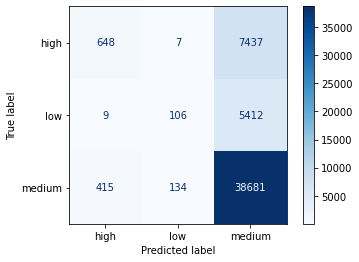

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.60      0.08      0.14      8092
         low       0.43      0.02      0.04      5527
      medium       0.75      0.99      0.85     39230

    accuracy                           0.75     52849
   macro avg       0.59      0.36      0.34     52849
weighted avg       0.69      0.75      0.66     52849



Testing prediciton accuracy Linear Regression

In [79]:
x = player_att_df.select_dtypes(exclude=['object', 'int64']).dropna()
x = x.drop(columns=['volleys'])
y = player_att_df.select_dtypes(exclude=['object', 'int64']).dropna()['volleys']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
r2_score = model.score(X_test, y_test)
print(r2_score*100,'%')

80.91884675194203 %


#### Predicting continuous features with Linear Regression

In [80]:
df_for_pred = player_att_df[player_att_df.isnull().any(axis=1)]
features_to_predict = ['volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle']

for feature in features_to_predict:
    df_for_pred.loc[df_for_pred[feature].isnull(), [feature]] = linear_predicting_missing_val(player_att_df, feature).round()

player_att_df = concat_predictions(player_att_df, df_for_pred)

#### Predicting categorical features with Logistic Regression

In [81]:
df_for_pred = player_att_df[player_att_df.isnull().any(axis=1)]
features_to_predict = ['attacking_work_rate', 'defensive_work_rate']

for feature in features_to_predict:
    df_for_pred.loc[df_for_pred[feature].isnull(), [feature]] = logistic_predicting_missing_val(player_att_df, feature)

player_att_df = concat_predictions(player_att_df, df_for_pred)

Finally we see that there is no missing data

In [82]:
percentage_of_nulls(player_att_df)

id                     0.0
player_fifa_api_id     0.0
player_api_id          0.0
date                   0.0
overall_rating         0.0
potential              0.0
preferred_foot         0.0
attacking_work_rate    0.0
defensive_work_rate    0.0
crossing               0.0
finishing              0.0
heading_accuracy       0.0
short_passing          0.0
volleys                0.0
dribbling              0.0
curve                  0.0
free_kick_accuracy     0.0
long_passing           0.0
ball_control           0.0
acceleration           0.0
sprint_speed           0.0
agility                0.0
reactions              0.0
balance                0.0
shot_power             0.0
jumping                0.0
stamina                0.0
strength               0.0
long_shots             0.0
aggression             0.0
interceptions          0.0
positioning            0.0
vision                 0.0
penalties              0.0
marking                0.0
standing_tackle        0.0
sliding_tackle         0.0
g

Let's take a look at the predicted data normality.

* <font color='orange'>Orange line</font> - actual KDE
* Black line - theoretical KDE

In [83]:
predicted_data_norm = df_for_pred[['volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle']]

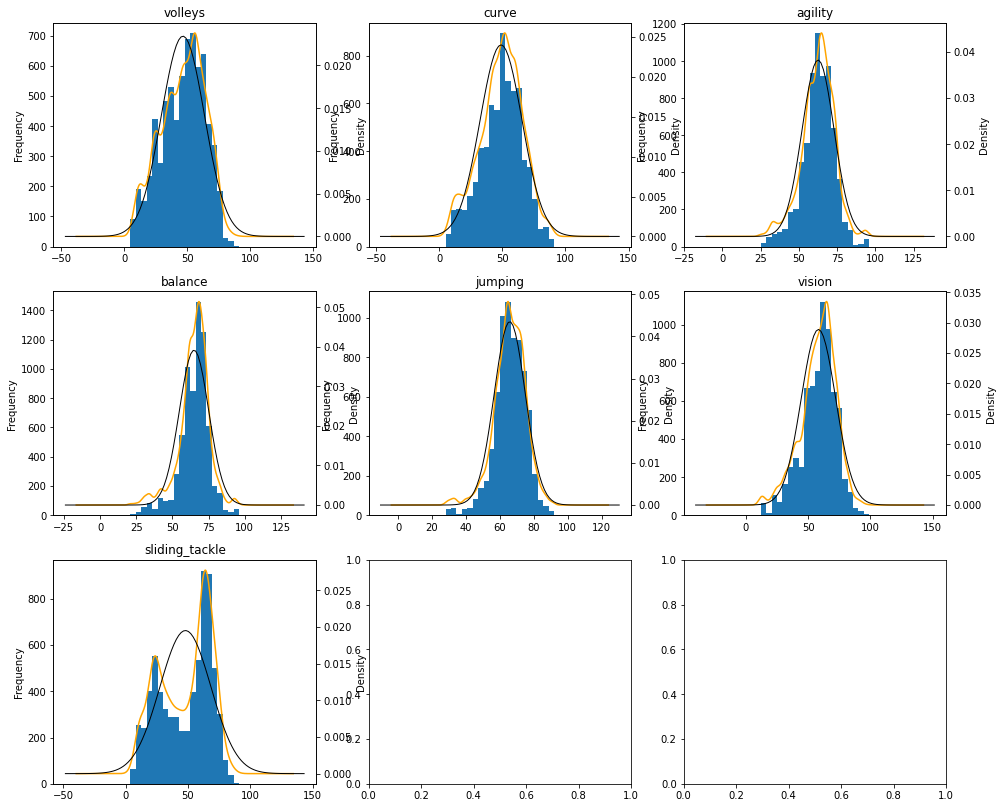

In [84]:
f, axes = plt.subplots(3,3, figsize=(16,14))

for col, ax in zip(predicted_data_norm.columns, axes.flat):
    ax2 = ax.twinx()
    predicted_data_norm[col].plot.hist(ax=ax, rot=0, bins=20)
    predicted_data_norm[col].plot.kde(ax=ax2, color='orange')
    mu, std = norm.fit(predicted_data_norm[col])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=1)
    ax.set_title(col)
plt.show()

We see that (except one feature that has 2 peaks), the data was nicely predicted with a normal distribution.

### What is the most popular players field formation and does it determine the team's victory?

The Match dataset consist information about coordinates of every player positions on a field. The so called Formation.

Formations are described mainly by three or four numbers in order to denote how many players are in each row of the formation, from the most defensive to the most advanced.

According to the [global sports content platform](https://www.sportskeeda.com/football/3-most-popular-football-formations-today), 4-3-3 formation is nowadays one of the most popular formation used in a football gradually replacing the former most popular 4-4-2 formation. It is an attacking formation with strong defense capabilities.

<h3><center>The 4-3-3 formation</center></h3>

![433.png](https://staticg.sportskeeda.com/editor/2020/08/dd252-15965687468793-800.jpg)

Our dataset consist matches up to year 2016. There is unfortunatelly no information about the latest games, but we could still see what was the most popular formations used at that time.

In [85]:
def field_formation(x, home_away):
    y = []
    # we skip the goalkeeper as he is not in formation
    for number in range(2, 12):
        if not pd.isnull(x[home_away + '_player_Y' + str(number)]):
            y.append(x[home_away + '_player_Y' + str(number)])
        else:
            return np.nan
    form = ''.join([str(i) for i in Counter(y).values()])
    return form

In [86]:
match_df["home_formation"] = match_df.apply(lambda x: field_formation(x, "home"), axis=1)
match_df["away_formation"] = match_df.apply(lambda x: field_formation(x, "away"), axis=1)

In [87]:
df1, df2 = pd.DataFrame(), pd.DataFrame()

df1[['result', 'formation']] = match_df[['home_team_res', 'home_formation']]
df2[['result', 'formation']] = match_df[['away_team_res', 'away_formation']]

formation_and_result = pd.concat([df1, df2])

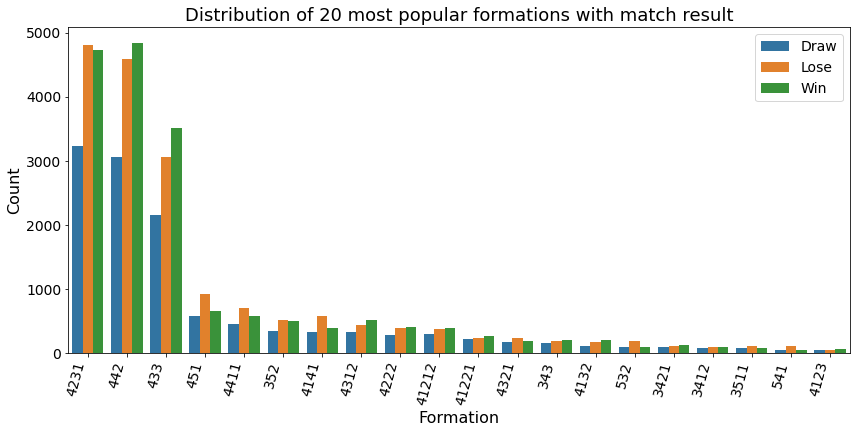

In [88]:
plt.figure(figsize=(14,6))

graph = sns.countplot(x='formation',
              data=formation_and_result,
              hue='result', 
              order = formation_and_result['formation'].value_counts().iloc[:20].index)

graph.set_xticklabels(
    graph.get_xticklabels(),
    rotation=75,
    horizontalalignment='right',
    fontsize=14)

title_and_labels(
    title = "Distribution of 20 most popular formations with match result",
    x_label = "Formation",
    y_label = "Count"
)
plt.legend(loc='best', fontsize=14)

plt.show()

As per graph above we see that the most popular formations are **4-2-3-1**, **4-4-2** and **4-3-3**. Although there is no guarantee of victory, but **4-3-3** stands out from the rest in terms of the slightly higher number of matches won using this scheme than the other.

What about the goals scored/missed ratio according to the field formation?

In [89]:
df1, df2, df3, df4 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

df1[['scored_goals', 'formation']] = match_df[['home_team_goal', 'home_formation']]
df2[['missed_goals', 'formation']] = match_df[['away_team_goal', 'home_formation']]
df3[['scored_goals', 'formation']] = match_df[['away_team_goal', 'away_formation']]
df4[['missed_goals', 'formation']] = match_df[['home_team_goal', 'away_formation']]

formation_and_goals = pd.concat(
    [df1.merge(df2, left_index=True, right_index=True).drop(columns=['formation_y']), 
     df3.merge(df4, left_index=True, right_index=True).drop(columns=['formation_y'])]).rename(columns={'formation_x': 'formation'})

In [90]:
formation_and_goals = pd.DataFrame(formation_and_goals.groupby(['formation']).agg({'formation':'count', 'scored_goals': 'mean', 'missed_goals':'mean'}))
formation_and_goals.rename(columns={'formation': 'count'}, inplace=True)

In [91]:
formation_and_goals = formation_and_goals[formation_and_goals['count'] > 50].reset_index()
formation_and_goals['ratio'] = formation_and_goals['scored_goals'] / formation_and_goals['missed_goals']

In [92]:
formation_and_goals.sort_values(by='ratio', ascending=False)

,formation,count,scored_goals,missed_goals,ratio
10,4213,70,1.485714,1.214286,1.223529
7,4123,171,1.555556,1.345029,1.156522
8,4132,491,1.415479,1.260692,1.122779
1,3421,349,1.363897,1.237822,1.101852
15,433,8728,1.480064,1.349450,1.096791
13,4312,1294,1.379444,1.274343,1.082474
6,41221,739,1.280108,1.202977,1.064117
0,3412,281,1.387900,1.327402,1.045576
5,41212,1071,1.450047,1.400560,1.035333
2,343,566,1.406360,1.358657,1.035111


* Ratio **=** 1 (on average teams **scores and miss same** amount of goals)
* Ratio **>** 1 (on average teams **scores more** goals than miss)
* Ratio **<** 1 (on average teams **scores less** goals than miss)

So one of the teams goal should be to have ratio > 1.

Again, we may notice a 4-3-3 formation on a high rank. Additionally, formations 4-1-2-3, 4-1-3-2 (also high on rank) are very similar to 4-3-3 (some call it as the same). So it's no wonder why this formation is so popular among the teams.

The leading formation 4-2-1-3 is a very young one. According to [Wiki](https://en.wikipedia.org/wiki/Formation_(association_football)) it was developed only in 2010 (while 4-3-3 in 1962) and is now  often called as future football formation.

Of course, keep in mind that these are the starting formations which may or may not change during the game.

### Bookmakers odds

This dataset consist bookmakers odds in decimal format. Decimal odds are shown as one number, which is the amount a winning bet would collect on a \\$1 bet. If the odds are listed as 6, a winning bet would receive \\$5 profit and the original \\$1 bet.

There are three type of bettings: **Home (H)**, **Draw (D)**, **Away (A)**

In [93]:
bookmakers_df = match_df.iloc[:,85:106]
bookmakers_df.sample()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA
9479,4.0,3.5,1.91,3.0,3.5,1.87,4.0,3.45,1.85,4.0,3.6,1.85,4.0,3.3,1.95,4.0,3.4,1.9,4.1,3.5,1.95


Let's convert bookmaker odds to probabilities and plot them to see distribution of probabilities of different bettings houses.

In [94]:
probabilities = pd.DataFrame()

for column in bookmakers_df.columns:
    probabilities[column] = 1 / bookmakers_df[column]

In [192]:
probabilities.sample()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA
22258,0.52356,0.30303,0.238095,0.540541,0.30303,0.238095,0.526316,0.30303,0.25641,0.52356,0.3125,0.285714,0.546448,0.3125,0.266667,0.540541,0.294118,0.230947,0.526316,0.307692,0.277778


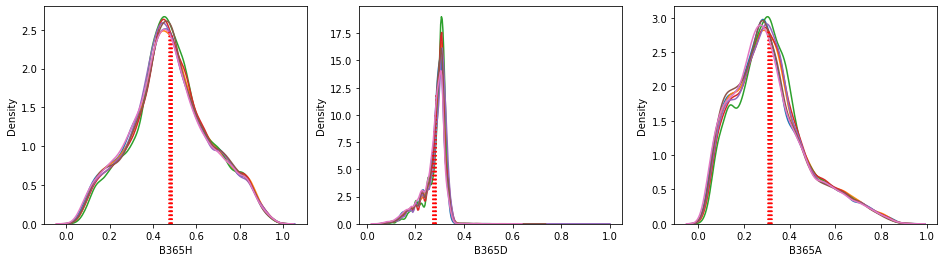

In [96]:
f, ax = plt.subplots(1,3, figsize=(16, 4))
x1 = ['Home', 'Draw', 'Away']
for i, result in enumerate(['H', 'D', 'A']):
    for column in ['B365', 'BW', 'IW', 'LB', 'WH', 'SJ', 'VC']:
        data = probabilities[column+result]
        sns.kdeplot(data=data, ax=ax[i])
        kdeline = ax[i].lines[0]
        mean = data.mean()
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        height = np.interp(mean, xs, ys)
        ax[i].vlines(mean, 0, height, color='red', linestyle=":")

From the plots above we see that probabilities distribution of all betting houses are very similar to each other.

Home team has an advantage as average probability (according to betting houses) for home team to win is the highest and stands ~0.47

In [97]:
def bettie_pred(row, columns):
    return row[columns].mean(axis=0)

In [98]:
match_df["bookie_home"] = probabilities.apply(lambda x: bettie_pred(x, ['B365H', 'BWH', 'IWH', 'LBH', 'WHH', 'SJH', 'VCH']), axis=1)
match_df["bookie_draw"] = probabilities.apply(lambda x: bettie_pred(x, ['B365D', 'BWD', 'IWD', 'LBD', 'WHD', 'SJD', 'VCD']), axis=1)
match_df["bookie_away"] = probabilities.apply(lambda x: bettie_pred(x, ['B365A', 'BWA', 'IWA', 'LBA', 'WHA', 'SJA', 'VCA']), axis=1)

In [99]:
def bookie_pred(row):
    if row['bookie_home'] == row[['bookie_home', 'bookie_draw', 'bookie_away']].max():
        return 'Win'
    elif row['bookie_draw'] == row[['bookie_home', 'bookie_draw', 'bookie_away']].max():
        return 'Draw'
    else:
        return 'Lose'

In [100]:
match_df["bookie_pred"] = match_df.apply(lambda x: bookie_pred(x), axis=1)

In [101]:
bookies_correctness = match_df[['home_team_res', 'bookie_pred']].dropna()

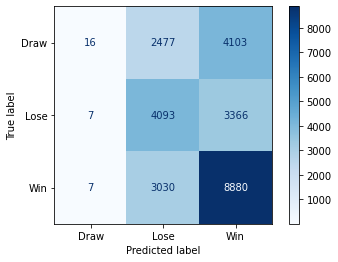

In [102]:
ConfusionMatrixDisplay.from_predictions(bookies_correctness['home_team_res'], bookies_correctness['bookie_pred'], cmap='Blues')

In [103]:
print(classification_report(bookies_correctness['home_team_res'], bookies_correctness['bookie_pred']))

              precision    recall  f1-score   support

        Draw       0.53      0.00      0.00      6596
        Lose       0.43      0.55      0.48      7466
         Win       0.54      0.75      0.63     11917

    accuracy                           0.50     25979
   macro avg       0.50      0.43      0.37     25979
weighted avg       0.51      0.50      0.43     25979



## STATISTICAL INFERENCES

### Inference approach: Confidence Interval for proportion

**Research Question:** What proportion of Home Teams in season 2014/2015 scored more than 40 goals per season?

We'll provide a 95% confidence interval estimate (lower and upper limits) for this population proportion.

In [104]:
teams_goals_40 = pd.read_sql_query('''WITH goals_per_team AS (
                                           SELECT 
                                               season,
                                               home_team_api_id AS id,
                                               SUM(home_team_goal) AS goals_sum
                                           FROM Match
                                           WHERE season = '2014/2015'
                                           GROUP BY 2)
                                      SELECT COUNT(id) as goals
                                      FROM goals_per_team
                                      WHERE goals_sum > 40
                                      UNION
                                      SELECT COUNT(id)
                                      FROM goals_per_team
                                      WHERE goals_sum < 40
                                      ;''', con)

In [105]:
print(f'Teams that scored more than 40 goals/season: {teams_goals_40.goals[0]}')
print(f'Teams that scored less than 40 goals/season: {teams_goals_40.goals[1]}')
print(f'Total teams played in season: {teams_goals_40.goals.sum()}')

Teams that scored more than 40 goals/season: 17
Teams that scored less than 40 goals/season: 167
Total teams played in season: 184


In [106]:
sample_size = 184
above_40_goals = 17
less_than_40_goals = 167

best_estimate = above_40_goals/sample_size

print(f'Proportion of teams that score more than 40 goals per season: {best_estimate}')

Proportion of teams that score more than 40 goals per season: 0.09239130434782608


In [107]:
estimated_std_err = np.sqrt((best_estimate*(1 - best_estimate))/sample_size)

print(f'Estimated standard error: {estimated_std_err}')

Estimated standard error: 0.02134793942158035


**Best Estimate ± "a few" standard errors**

Large sample size → 95% multiplier = 1.96

In [108]:
lower = best_estimate - (1.96 * estimated_std_err)
upper = best_estimate + (1.96 * estimated_std_err)

print(f'Confidence interval: {lower} - {upper}')

Confidence interval: 0.05054934308152859 - 0.13423326561412358


95% confidence interval for the proportion of Home Teams in season 2014/2015 that scored more than 40 goals per season:

**0.0505 - 0.1342**

### Inference approach: Single variable using Hypothesis Testing

In [109]:
avg_goal_per_match = pd.read_sql_query(''' SELECT 
                                               home_team_goal as goals
                                           FROM Match
                                           WHERE season = '2011/2012'
                                           ;''', con)
avg_goal_per_match.describe()

,goals
count,3220.000000
mean,1.572671
std,1.339068
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


**Research Question:** Does Home Team in a season of 2011/2012 on average scores more than 1.5 goal per game or the population average different%?

We'll perform a one-sample test (two-tailed) to either **reject** or **fail to reject** null hypothesis: goal per game - 1.5

**Null**: Population mean (µ) is 1.5

**Alternative**: Population mean is **not equal** to 1.50

Significance level(alpha): 5%(.05)

In [110]:
sample_size = 3220
best_estimate = 1.572671
std_dev = 1.339068

estimated_std_err = std_dev/np.sqrt(sample_size)

print(f'Estimated standard error: {estimated_std_err}')

Estimated standard error: 0.023597972782602474


In [111]:
t = (best_estimate - 1.5) / (std_dev/np.sqrt(sample_size))
print(f't statistic: {t}')

t statistic: 3.079544190913568


With a [P-value calculator](https://www.statology.org/t-score-p-value-calculator/)
we find that **p-value = 0.00105**

Since this p-value is much less than our chosen alpha level of .05, we strongly reject the null hypothesis. We have sufficient evidence to say that the true mean of goals for for home teams in a season of 2011/2012 is different than 1.5

## PREDICTIONS

### Can we predict which team will win the match?

For match result prediction we can get:

* We know which players are registered for the match, thus we'll get overall rating of every player from attributes.
* Calculate how many wins teams already had before current match.
* Calculate the wins/losses of all matches played against each other that took place earlier.
* We'll take teams starting formations
* We'll take bookmakers probabilities.

we may try to predict the match result for home team (win, draw or lose).

In [112]:
match_players_data = match_df.iloc[:,55:77]
match_players_data[['date', 'match_api_id', 'home_team_goal', 'away_team_goal']] = match_df[['date', 'match_api_id', 'home_team_goal', 'away_team_goal']]
match_players_data.dropna(inplace=True)

In [113]:
players_ratings = player_att_df[['player_api_id', 'date', 'overall_rating']]
players_ratings.sample()

,player_api_id,date,overall_rating
133978,97038,2009-08-30 00:00:00,68.0


In [114]:
def get_player_rating(row, players_ratings):
    player_stat_df = pd.DataFrame()
    for column in row[:22].index:
        player_id = row[column]
        date = row['date']
        player_stat = players_ratings[players_ratings['player_api_id'] == player_id]
        player_stat_by_date = player_stat[player_stat['date'] <= date].sort_values(by='date', ascending=False).iloc[:1,-1:].reset_index(drop = True)
        player_stat_by_date.rename(columns={'overall_rating': column}, inplace=True)
        player_stat_df = pd.concat([player_stat_df, player_stat_by_date], axis=1)
    player_stat_df['match_api_id'] = row.match_api_id
    return player_stat_df.iloc[0]

In [115]:
match_w_players_ratings = match_players_data.apply(lambda x: get_player_rating(x, players_ratings), axis=1)

In [116]:
fifa_data_df = match_w_players_ratings.merge(match_df[['home_team_goal', 
                                                       'away_team_goal',
                                                       'home_team_res',
                                                       'league_id',
                                                       'season',
                                                       'date',
                                                       'home_formation',
                                                       'away_formation',
                                                       'bookie_home',
                                                       'bookie_draw',
                                                       'bookie_away',
                                                       'match_api_id'
                                                      ]], how='left', on='match_api_id')

In [117]:
fifa_data_df.sample()

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,match_api_id,home_team_goal,away_team_goal,home_team_res,league_id,season,date,home_formation,away_formation,bookie_home,bookie_draw,bookie_away
20354,64.0,56.0,61.0,67.0,59.0,50.0,47.0,61.0,62.0,59.0,52.0,55.0,58.0,59.0,42.0,55.0,69.0,54.0,65.0,57.0,59.0,62.0,768479.0,2,1,Win,24558,2009/2010,2010-05-01 00:00:00,442,442,NaN,NaN,NaN


In [118]:
def get_team_wins_lost(row, matches):
    match_id = row['match_api_id']
    date = row['date']
    season = row['season']
    home_team = match_df['home_team_api_id'][match_df['match_api_id'] == match_id]
    
    # Data of all matches with a home team
    total_plays = match_df[match_df['home_team_api_id'] == home_team.item()]
    
    # Filtering out only matches that were in the past from current match
    total_plays_to_date = total_plays[total_plays['date'] < date]
    
    if total_plays_to_date.shape[0] == 0:
        return [0, 0]
    
    # Counting Home and Away team wins
    home_team_won_to_date = total_plays_to_date['home_team_res'][total_plays_to_date['home_team_res'] == 'Win'].count()
    away_team_won_to_date = total_plays_to_date['away_team_res'][total_plays_to_date['away_team_res'] == 'Win'].count()
    
    return [home_team_won_to_date, away_team_won_to_date]

In [119]:
fifa_data_df[['home_team_won_to_date', 'away_team_won_to_date']] = fifa_data_df.apply(lambda x: get_team_wins_lost(x, match_df), axis=1, result_type="expand")

In [120]:
def get_between_wins_lost(row, matches):
    match_id = row['match_api_id']
    date = row['date']
    season = row['season']
    home_team = match_df['home_team_api_id'][match_df['match_api_id'] == match_id]
    away_team = match_df['away_team_api_id'][match_df['match_api_id'] == match_id]
    
    # Data of all matches between these two teams
    total_plays = match_df[(match_df['home_team_api_id'] == home_team.item()) & (match_df['away_team_api_id'] == away_team.item())]
    
    # Filtering out only matches that were in the past from current match
    total_plays_to_date = total_plays[total_plays['date'] < date]
    
    if total_plays_to_date.shape[0] == 0:
        return [0, 0]
    
    # Getting result of match (Win, Draw or Lose)
    total_plays_to_date[['home_between_res', "away_between_res"]] = total_plays_to_date.apply(match_result, axis = 1, result_type="expand")
    
    # Counting Home and Away team wins
    home_team_between_won_to_date = total_plays_to_date['home_between_res'][total_plays_to_date['home_between_res'] == 'Win'].count()
    away_team_between_won_to_date = total_plays_to_date['away_between_res'][total_plays_to_date['away_between_res'] == 'Win'].count()
    
    return [home_team_between_won_to_date, away_team_between_won_to_date]

In [121]:
fifa_data_df[['home_team_between_won_to_date', 'away_team_between_won_to_date']] = fifa_data_df.apply(lambda x: get_between_wins_lost(x, match_df), axis=1, result_type="expand")

In [122]:
def get_total_goals(row, matches):
    match_id = row['match_api_id']
    date = row['date']
    season = row['season']
    home_team = match_df['home_team_api_id'][match_df['match_api_id'] == match_id]
    
    # Data of all matches between these two teams
    total_goals = match_df[match_df['home_team_api_id'] == home_team.item()]
    
    # Filtering out only matches that were in the past from current match
    total_goals_to_date = total_goals[total_goals['date'] < date]
    
    if total_goals_to_date.shape[0] == 0:
        return [0, 0]
    
    # Getting sum of all scored goals for Home and Away teams
    home_total_goals = total_goals_to_date['home_team_goal'].sum()
    away_total_goals = total_goals_to_date['away_team_goal'].sum()
    
    return [home_total_goals, away_total_goals]

In [123]:
fifa_data_df[['home_total_goals', 'away_total_goals']] = fifa_data_df.apply(lambda x: get_total_goals(x, match_df), axis=1, result_type="expand")

In [124]:
def avg_home_goals(row, matches):
    match_id = row['match_api_id']
    date = row['date']
    season = row['season']
    as_home_team = match_df['home_team_api_id'][match_df['match_api_id'] == match_id]
    as_away_team = match_df['away_team_api_id'][match_df['match_api_id'] == match_id]
    
    total_goals = match_df[match_df['home_team_api_id'] == as_home_team.item()]
    avg_home_goals_to_date = total_goals[total_goals['date'] < date]
    if avg_home_goals_to_date.shape[0] == 0:
        home_avg_goals = 0
    else:
        home_avg_goals = avg_home_goals_to_date['home_team_goal'].mean()
    
    total_goals = match_df[match_df['away_team_api_id'] == as_away_team.item()]
    avg_away_goals_to_date = total_goals[total_goals['date'] < date]
    if avg_away_goals_to_date.shape[0] == 0:
        away_avg_goals = 0
    else:
        away_avg_goals = avg_home_goals_to_date['away_team_goal'].mean()
    
    return [home_avg_goals, away_avg_goals]

In [125]:
fifa_data_df[['home_avg_goals', 'away_avg_goals']] = fifa_data_df.apply(lambda x: avg_home_goals(x, match_df), axis=1, result_type="expand")

In [126]:
def avg_conceled_goals(row, matches):
    match_id = row['match_api_id']
    date = row['date']
    season = row['season']
    as_home_team = match_df['home_team_api_id'][match_df['match_api_id'] == match_id]
    as_away_team = match_df['away_team_api_id'][match_df['match_api_id'] == match_id]
    
    total_goals = match_df[match_df['home_team_api_id'] == as_home_team.item()]
    avg_home_goals_to_date = total_goals[(total_goals['season'] == season) & (total_goals['date'] < date)]
    avg_home_conceled_goals = avg_home_goals_to_date['away_team_goal'].mean()
    
    total_goals = match_df[match_df['away_team_api_id'] == as_away_team.item()]
    avg_away_goals_to_date = total_goals[(total_goals['season'] == season) & (total_goals['date'] < date)]
    avg_away_conceled_goals = avg_home_goals_to_date['home_team_goal'].mean()
    
    return [avg_home_conceled_goals, avg_away_conceled_goals]

In [127]:
fifa_data_df[['avg_home_conceled_goals', 'avg_away_conceled_goals']] = fifa_data_df.apply(lambda x: avg_conceled_goals(x, match_df), axis=1, result_type="expand")

In [128]:
def avg_league_goals(row, matches):
    league_id = row['league_id']
    date = row['date']
    season = row['season']
    total_goals = match_df[match_df['league_id'] == league_id]
    total_goals_to_date = total_goals[total_goals['date'] < date]
    if total_goals_to_date.shape[0] == 0:
        return [0, 0]
    league_home_goals = total_goals_to_date['home_team_goal'].mean()
    league_away_goals = total_goals_to_date['away_team_goal'].mean()
    
    return [league_home_goals, league_away_goals]

In [129]:
fifa_data_df[['league_home_goals', 'league_away_goals']] = fifa_data_df.apply(lambda x: avg_league_goals(x, match_df), axis=1, result_type="expand")

In [130]:
def attack_strength(row, matches):
    if not row['league_home_goals']:
        return 0
    else:
        attack_strength = row['home_avg_goals'] / row['league_home_goals']
    return attack_strength

In [131]:
fifa_data_df['attack_strength'] = fifa_data_df.apply(lambda x: attack_strength(x, match_df), axis=1, result_type="expand")

In [132]:
def defense_strength(row, matches):
    if not row['league_away_goals']:
        return 0
    else:
        defense_strength = row['away_avg_goals'] / row['league_away_goals']
    return defense_strength

In [133]:
fifa_data_df['defense_strength'] = fifa_data_df.apply(lambda x: defense_strength(x, match_df), axis=1, result_type="expand")

In [134]:
fifa_data_df.sample()

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,match_api_id,home_team_goal,away_team_goal,home_team_res,league_id,season,date,home_formation,away_formation,bookie_home,bookie_draw,bookie_away,home_team_won_to_date,away_team_won_to_date,home_team_between_won_to_date,away_team_between_won_to_date,home_total_goals,away_total_goals,home_avg_goals,away_avg_goals,avg_home_conceled_goals,avg_away_conceled_goals,league_home_goals,league_away_goals,attack_strength,defense_strength
3194,83.0,82.0,86.0,80.0,78.0,84.0,86.0,79.0,87.0,83.0,83.0,73.0,74.0,75.0,71.0,70.0,78.0,72.0,70.0,72.0,73.0,74.0,1474928.0,4,2,Win,1729,2013/2014,2014-01-18 00:00:00,442,4141,0.885035,0.120381,0.050666,80,13,0,0,249,83,2.371429,0.790476,0.6,3.8,1.567773,1.156872,1.51261,0.683287


In [ ]:
fifa_data_df

In [135]:
fifa_data_df.dropna(inplace=True)

### Logistic regression

In [136]:
x = fifa_data_df
x = x.drop(columns=[
    'match_api_id', 
    'home_team_goal',
    'away_team_goal',
    'home_team_res', 
    'date', 
    'season',
    'league_id', 
])

y = fifa_data_df['home_team_res']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=11, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]}]

gridsearch = GridSearchCV(LogisticRegression(max_iter=1000), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'C': 0.001, 'solver': 'liblinear'}

In [138]:
log_reg_model = LogisticRegression(solver = "newton-cg", penalty='none', C=0.1, random_state=11)
log_reg_model.fit(X_train, y_train)
y_pred_log = log_reg_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_log)
r2_score = log_reg_model.score(X_test, y_test)
print(r2_score*100,'%')

53.408480944712835 %


In [139]:
# Predicting Cross Validation Score
cv_lr = cross_val_score(estimator = log_reg_model, X = X_train, y = y_train, cv = 10)
print("CV: ", cv_lr.mean())

CV:  0.5322892193098513


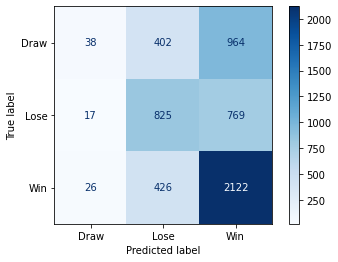

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, cmap='Blues')
plt.show()

In [141]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

        Draw       0.47      0.03      0.05      1404
        Lose       0.50      0.51      0.51      1611
         Win       0.55      0.82      0.66      2574

    accuracy                           0.53      5589
   macro avg       0.51      0.45      0.41      5589
weighted avg       0.52      0.53      0.46      5589



### K-Nearest Neighbors (K-NN)

In [142]:
parameters = {"n_neighbors": range(1, 100)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'n_neighbors': 91}

In [143]:
knn_model = KNeighborsClassifier(n_neighbors=55).fit(X_train, y_train)
y_pred_knn = gridsearch.predict(X_test)
r2_score = knn_model.score(X_test, y_test)
print(r2_score*100,'%')

50.796206834854175 %


In [144]:
# Predicting Cross Validation Score
cv_knn = cross_val_score(estimator = knn_model, X = X_train, y = y_train, cv = 10)
print("CV: ", cv_knn.mean())

CV:  0.5181761414197534


In [145]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

        Draw       0.23      0.04      0.06      1404
        Lose       0.50      0.44      0.47      1611
         Win       0.53      0.82      0.65      2574

    accuracy                           0.51      5589
   macro avg       0.42      0.43      0.39      5589
weighted avg       0.45      0.51      0.45      5589



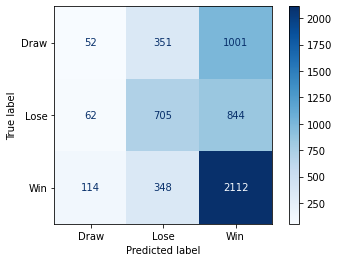

In [146]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues')
plt.show()

### RandomForestClassifier

In [147]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=50) 

param_grid = {
    "n_estimators": [50, 100, 500, 1000],
    "max_depth": [1, 5, 10, 25],
    'bootstrap': [False, True]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'bootstrap': False, 'max_depth': 10, 'n_estimators': 500}


In [148]:
rf = RandomForestClassifier(max_depth=10, random_state=44, n_estimators=100, bootstrap = False).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_score = rf.score(X_test, y_test)
print(r2_score*100,'%')

52.925389157273216 %


In [149]:
# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
print("CV: ", cv_rf.mean())

CV:  0.5311386182900245


In [150]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

        Draw       0.26      0.01      0.01      1404
        Lose       0.50      0.49      0.49      1611
         Win       0.54      0.84      0.66      2574

    accuracy                           0.53      5589
   macro avg       0.44      0.44      0.39      5589
weighted avg       0.46      0.53      0.45      5589



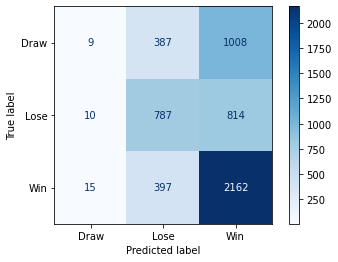

In [151]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')
plt.show()

### ExtraTreesClassifier

In [152]:
extree = ExtraTreesClassifier().fit(X_train, y_train)
y_pred_extree = extree.predict(X_test)
r2_score = extree.score(X_test, y_test)
print(r2_score*100,'%')

51.47611379495437 %


In [153]:
# Predicting Cross Validation Score
cv_extree = cross_val_score(estimator = extree, X = X_train, y = y_train, cv = 10)
print("CV: ", cv_extree.mean())

CV:  0.5190198174105062


In [154]:
print(classification_report(y_test, y_pred_extree))

              precision    recall  f1-score   support

        Draw       0.29      0.08      0.12      1404
        Lose       0.49      0.47      0.48      1611
         Win       0.55      0.78      0.64      2574

    accuracy                           0.51      5589
   macro avg       0.44      0.44      0.42      5589
weighted avg       0.47      0.51      0.47      5589



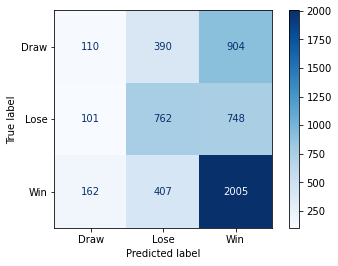

In [155]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_extree, cmap='Blues')
plt.show()

### SVM

In [156]:
svc = SVC().fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
r2_score = svc.score(X_test, y_test)
print(r2_score*100,'%')

52.71068169618894 %


In [157]:
# Predicting Cross Validation Score
cv_svc = cross_val_score(estimator = svc, X = X_train, y = y_train, cv = 10)
print("CV: ", cv_svc.mean())

CV:  0.5289144564925679


In [158]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

        Draw       0.44      0.01      0.03      1404
        Lose       0.50      0.44      0.47      1611
         Win       0.54      0.86      0.66      2574

    accuracy                           0.53      5589
   macro avg       0.49      0.44      0.39      5589
weighted avg       0.50      0.53      0.45      5589



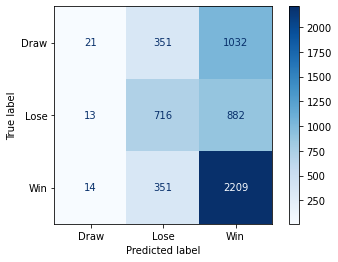

In [159]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, cmap='Blues')
plt.show()

### Naive Bayes

In [160]:
naive_model = GaussianNB().fit(X_train, y_train)
y_pred_naive = naive_model.predict(X_test)
r2_score = naive_model.score(X_test, y_test)
print(r2_score*100,'%')

46.78833422794775 %


In [161]:
# Predicting Cross Validation Score
cv_naive = cross_val_score(estimator = naive_model, X = X_train, y = y_train, cv = 10)
print("CV: ", cv_naive.mean())

CV:  0.47698839158336825


In [162]:
print(classification_report(y_test, y_pred_naive))

              precision    recall  f1-score   support

        Draw       0.29      0.30      0.29      1404
        Lose       0.44      0.58      0.50      1611
         Win       0.62      0.49      0.55      2574

    accuracy                           0.47      5589
   macro avg       0.45      0.46      0.45      5589
weighted avg       0.49      0.47      0.47      5589



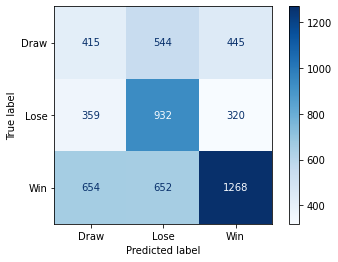

In [163]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_naive, cmap='Blues')
plt.show()

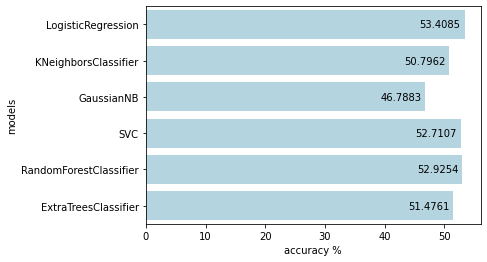

In [164]:
models = [log_reg_model, knn_model, naive_model, svc, rf, extree]
result = []
results = pd.DataFrame(columns= ["models", "accuracy"])
for x in models:
    names = x.__class__.__name__
    y_preds = x.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)    
    result = pd.DataFrame([[names, accuracy * 100]], columns= ["models", "accuracy"])
    results = pd.concat([results, result])
    
ax = sns.barplot(x = "accuracy", y = "models", data = results, color = "lightblue")
ax.bar_label(ax.containers[0], padding=-45)
plt.xlabel("accuracy %");

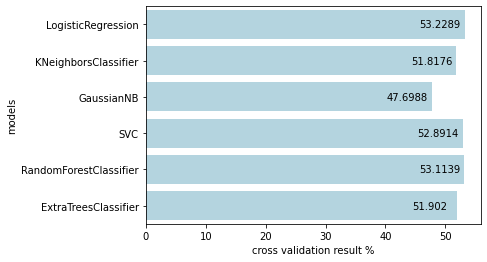

In [165]:
models = [log_reg_model, knn_model, naive_model, svc, rf, extree]
cv = [cv_lr, cv_knn, cv_naive, cv_svc, cv_rf, cv_extree]
result = []
results = pd.DataFrame(columns= ["models", "cv"])

for model, cv in zip(models, cv):
    name = model.__class__.__name__
    result = pd.DataFrame([[name, cv.mean() * 100]], columns= ["models", "cv"])
    results = pd.concat([results, result])

ax = sns.barplot(x = "cv", y = "models", data = results, color = "lightblue")
ax.bar_label(ax.containers[0], padding=-45)
plt.xlabel("cross validation result %");

### Can we predict how many goals team will score in each match?

We'll take the same dataset we made for match result prediction, but with some modifications.

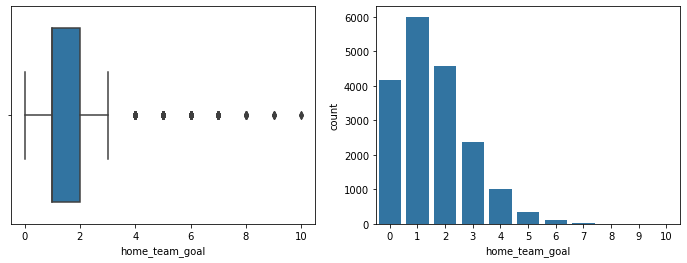

In [166]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.boxplot(x=fifa_data_df.home_team_goal, ax=ax[0])
sns.countplot(x=fifa_data_df.home_team_goal, ax=ax[1], color='#1F77B4')
plt.show()

In [167]:
fifa_data_df.home_team_goal.describe()

count    18627.000000
mean         1.557739
std          1.303603
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: home_team_goal, dtype: float64

From the plots and describe above we see that feature of home_team_goal has outliers. 75% of all matches not exceeded 2 goals.

An outlier is a data point that lies outside the overall pattern in a distribution.

A commonly used rule says that a data point is an outlier if it is more than $1.5·IQR$ above the third quartile or below the first quartile. Said differently, low outliers are below $ Q1 - 1,5·IQR$ and high outliers are above $Q3 + 1.5·IQR$

In [168]:
def num_of_outliers(dataset, features, limit):
    outliers = []
    for col in features:
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers.extend(dataset[(dataset[col] < (Q1 - 1.5 * IQR)) | (dataset[col] > (Q3 + 1.5 * IQR))].index)
    outliers = Counter(outliers)
    filter_outliers = [index for index, count in outliers.items() if count >= limit]
    return filter_outliers

In [169]:
print(f"Number of outliers: {len(num_of_outliers(fifa_data_df, fifa_data_df[['home_team_goal']].columns, 1))}")

Number of outliers: 1509


In [170]:
fifa_data_no_outliers = fifa_data_df.drop(num_of_outliers(fifa_data_df, fifa_data_df[['home_team_goal']].columns, 1), axis = 0)

In [171]:
fifa_data_no_outliers.sample()

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,match_api_id,home_team_goal,away_team_goal,home_team_res,league_id,season,date,home_formation,away_formation,bookie_home,bookie_draw,bookie_away,home_team_won_to_date,away_team_won_to_date,home_team_between_won_to_date,away_team_between_won_to_date,home_total_goals,away_total_goals,home_avg_goals,away_avg_goals,avg_home_conceled_goals,avg_away_conceled_goals,league_home_goals,league_away_goals,attack_strength,defense_strength
1267,83.0,77.0,74.0,78.0,72.0,75.0,73.0,67.0,73.0,76.0,78.0,73.0,70.0,69.0,69.0,69.0,65.0,67.0,74.0,75.0,74.0,76.0,489178.0,2,2,Draw,1729,2008/2009,2008-11-22 00:00:00,442,4312,0.554377,0.294534,0.230966,3,2,0,0,8,6,1.333333,1.0,1.0,1.333333,1.44186,1.286822,0.924731,0.777108


### Logistic regression

In [172]:
x = fifa_data_no_outliers.drop(columns=[
    'match_api_id', 
    'home_team_goal', 
    'away_team_goal', 
    'home_team_res',
    'date', 
    'season', 
    'home_formation', 
    'away_formation'
])
y = fifa_data_no_outliers['home_team_goal']

X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.2, random_state=11, stratify=y)

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [173]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]}]

gridsearch = GridSearchCV(LogisticRegression(max_iter=1000), parameters)
gridsearch.fit(X_train2, y_train2)
gridsearch.best_params_

{'C': 0.001, 'solver': 'liblinear'}

In [174]:
log_reg_model2 = LogisticRegression(C=0.001, solver='liblinear' ,random_state=12)

log_reg_model2.fit(X_train2, y_train2)

y_pred_log = log_reg_model2.predict(X_test2)
r2_score = log_reg_model2.score(X_test2, y_test2)
print(r2_score*100,'%')

36.56542056074766 %


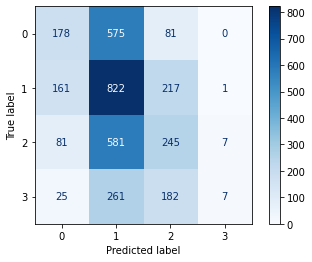

In [175]:
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_log, cmap='Blues')
plt.show()

In [176]:
print(classification_report(y_test2, y_pred_log))

              precision    recall  f1-score   support

           0       0.40      0.21      0.28       834
           1       0.37      0.68      0.48      1201
           2       0.34      0.27      0.30       914
           3       0.47      0.01      0.03       475

    accuracy                           0.37      3424
   macro avg       0.39      0.30      0.27      3424
weighted avg       0.38      0.37      0.32      3424



### K-NN

In [177]:
parameters = {"n_neighbors": range(1, 100)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train2, y_train2)
gridsearch.best_params_

{'n_neighbors': 98}

In [178]:
knn_model2 = KNeighborsClassifier(n_neighbors=98).fit(X_train2, y_train2)
y_pred_knn2 = knn_model2.predict(X_test2)
r2_score = knn_model2.score(X_test2, y_test2)
print(r2_score*100,'%')

35.251168224299064 %


In [179]:
print(classification_report(y_test2, y_pred_knn2))

              precision    recall  f1-score   support

           0       0.37      0.17      0.23       834
           1       0.36      0.74      0.48      1201
           2       0.31      0.19      0.24       914
           3       0.19      0.01      0.02       475

    accuracy                           0.35      3424
   macro avg       0.31      0.28      0.24      3424
weighted avg       0.33      0.35      0.29      3424



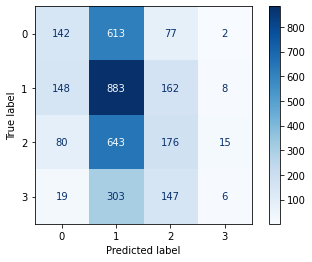

In [180]:
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_knn2, cmap='Blues')
plt.show()

### RandomForestClassifier

In [181]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=50) 

param_grid = {
    "n_estimators": [50, 100, 500, 1000],
    "max_depth": [1, 5, 10, 25],
    'bootstrap': [False, True]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train2, y_train2)
print(CV_rfc.best_params_)

{'bootstrap': True, 'max_depth': 10, 'n_estimators': 500}


In [182]:
rf2 = RandomForestClassifier(max_depth=10, random_state=44, n_estimators=500, bootstrap = False).fit(X_train2, y_train2)
y_pred_rf2 = rf2.predict(X_test2)
r2_score = rf2.score(X_test2, y_test2)
print(r2_score*100,'%')

36.74065420560748 %


In [183]:
print(classification_report(y_test2, y_pred_rf2))

              precision    recall  f1-score   support

           0       0.42      0.18      0.25       834
           1       0.37      0.72      0.49      1201
           2       0.33      0.25      0.29       914
           3       0.37      0.03      0.06       475

    accuracy                           0.37      3424
   macro avg       0.37      0.30      0.27      3424
weighted avg       0.37      0.37      0.32      3424



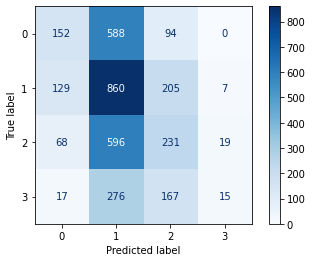

In [184]:
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_rf2, cmap='Blues')
plt.show()

### SVM

In [185]:
svc2 = SVC().fit(X_train2, y_train2)
y_pred_svc2 = svc2.predict(X_test2)
r2_score = svc2.score(X_test2, y_test2)
print(r2_score*100,'%')

36.56542056074766 %


In [186]:
print(classification_report(y_test2, y_pred_svc2))

              precision    recall  f1-score   support

           0       0.41      0.15      0.22       834
           1       0.37      0.77      0.50      1201
           2       0.33      0.22      0.26       914
           3       0.32      0.01      0.02       475

    accuracy                           0.37      3424
   macro avg       0.36      0.29      0.25      3424
weighted avg       0.36      0.37      0.30      3424



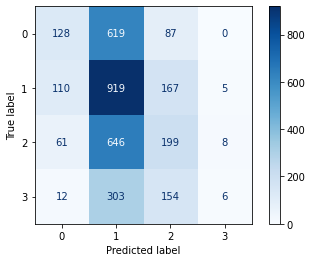

In [187]:
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_svc2, cmap='Blues')
plt.show()

### Naive Bayes

In [188]:
naive_model2 = GaussianNB().fit(X_train2, y_train2)
y_pred_naive2 = naive_model2.predict(X_test2)
r2_score = naive_model2.score(X_test2, y_test2)
print(r2_score*100,'%')

32.447429906542055 %


In [189]:
print(classification_report(y_test2, y_pred_naive2))

              precision    recall  f1-score   support

           0       0.34      0.48      0.40       834
           1       0.36      0.34      0.35      1201
           2       0.31      0.11      0.16       914
           3       0.25      0.43      0.32       475

    accuracy                           0.32      3424
   macro avg       0.32      0.34      0.31      3424
weighted avg       0.33      0.32      0.31      3424



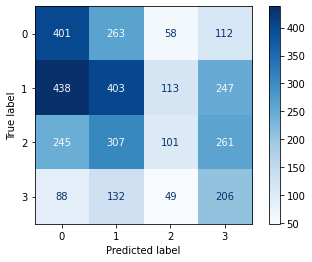

In [190]:
ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_naive2, cmap='Blues')
plt.show()

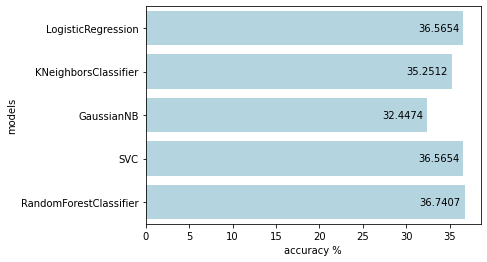

In [191]:
models = [log_reg_model2, knn_model2, naive_model2, svc2, rf2]
result = []
results = pd.DataFrame(columns= ["models", "accuracy"])
for x in models:
    names = x.__class__.__name__
    y_preds = x.predict(X_test2)
    accuracy = accuracy_score(y_test2, y_preds)    
    result = pd.DataFrame([[names, accuracy * 100]], columns= ["models", "accuracy"])
    results = pd.concat([results, result])
    
ax = sns.barplot(x = "accuracy", y = "models", data = results, color = "lightblue")
ax.bar_label(ax.containers[0], padding=-45)
plt.xlabel("accuracy %");

## Conclusions

Predicting the football game is difficult. To predict a Draw game is even more difficult. The seemingly stronger team will not necessarily win and may end up in a Draw for a variety of reasons. Result of the match could be influenced by hundreds of things, some of them aren't even measurable. As we saw earlier even bookmakers are far from perfect, but nevertheless I'm happy with the result. Another thing is predicting the number of goals. Desirable performance could be much more better.

I think predictions could be improved with additional data sources (like team avg. possesion of the ball, chance of receiving penalty during the game etc.). There is much more data that could be aggregated and included.